In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

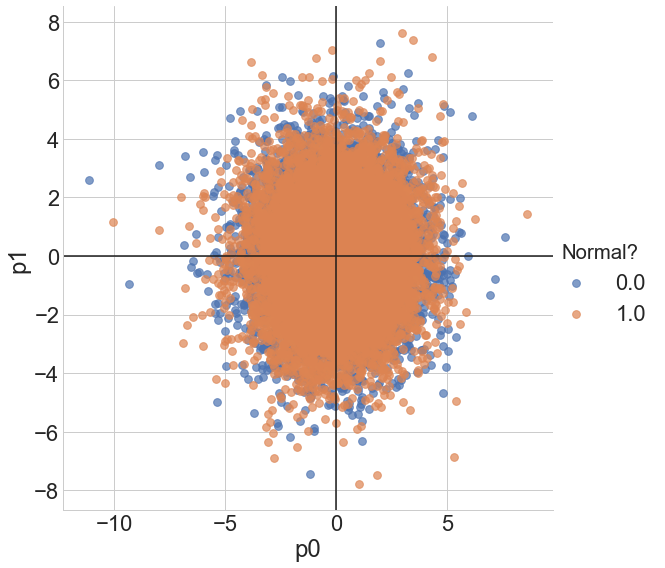

In [2]:
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
from scipy.io import wavfile
import numpy as np
from librosa.core import resample

sample_rate, samples = wavfile.read('audio_normal.wav')
#downsampling to 10000Hz
sr = 9000
resampled = resample(samples.astype(np.float32),sample_rate,sr) 
#make sure every signal is within the range of (0,1)
samples_casted = resampled / (2.**15) 
seg_len = sr/40 #25ms
overlap = seg_len*0.6  #60% overlap
f, t, Zxx = signal.stft(samples_casted, fs = sr, nperseg = seg_len, noverlap = overlap)
Zxx_abs = np.abs(Zxx)
audio_normal = Zxx.real

cols = ['Normal?']
for i in range(len(f)):
    cols.append((str(f[i])+'Hz'))
    
A_data = np.array([[0.0 for i in range(len(f)+1)] for i in range(len(t))])
for i in range(1,len(t)):
    row = np.array([1.0])
    row = np.append(row, audio_normal[:,i])
    A_data[i] = row
df = pd.DataFrame(np.array([A_data[i] for i in range(len(t))]), columns = cols)


sample_rate, samples = wavfile.read('audio_abnormal.wav')
#downsampling to 9000Hz
sr = 9000
resampled = resample(samples.astype(np.float32),sample_rate,sr) 

#make sure every signal is within the range of (0,1)
samples_casted = resampled / (2.**15) 
seg_len = sr/40 #25ms
overlap = seg_len*0.6  #60% overlap
f, t, Zxx = signal.stft(samples_casted, fs = sr, nperseg = seg_len, noverlap = overlap)
Zxx_abs = np.abs(Zxx)

audio_abnormal = Zxx.real
cols = ['Normal?']
for i in range(len(f)):
    cols.append((str(f[i])+'Hz'))
    
A_data = np.array([[0.0 for i in range(len(f)+1)] for i in range(len(t))])
for i in range(1,len(t)):
    row = np.array([0.0])
    row = np.append(row, audio_abnormal[:,i])
    A_data[i] = row
df_audio = pd.DataFrame(np.array([A_data[i] for i in range(len(t))]), columns = cols)
#DataFrame appending --> Mixed audio
df_audio = df_audio.append(df)

#####PCA#####
Audio_s = df_audio.iloc[:,1:]
#X: shifted dataset (each feature has mean value of zero)
X = Audio_s - Audio_s.mean()
#Z: shifted and standardized dataset 
Z = X / Audio_s.std()
U, S, Vt = np.linalg.svd(Z, full_matrices=False)
variances = S**2
V = Vt.T

tot = sum(variances)
var_exp = [(i / tot)*100 for i in variances]
cum_var_exp = np.cumsum(var_exp)

###Take n_components = 50
Zstar = Z@V[:,:50]
df_audio['p0'] = Zstar.values[:,0]
df_audio['p1'] = Zstar.values[:,1]

#PCA plotting for PC0 and PC1
g1 = sns.lmplot('p0', 'p1', df_audio, hue='Normal?', fit_reg=False, height=8, scatter_kws={'alpha':0.7,'s':60})
ax = g1.axes[0,0]
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
headers = df_audio.columns.values.tolist()

In [3]:
audio_pca = Zstar

In [4]:
#abnormal bee sounds
audio_pca["Normal?"] = 0.0
#normal bee sounds starting from index 12002
audio_pca["Normal?"][12002:] = 1.0

In [5]:
audio_pca

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Normal?
0,-0.019155,-0.002557,-0.002534,-0.005877,0.004355,-0.015456,0.002539,-0.018969,-0.000474,0.012799,...,0.007054,-0.006031,0.008233,0.000468,0.001704,0.003034,0.006221,0.005144,-0.009466,0.0
1,0.880227,0.043249,0.810463,-0.525779,-0.070669,-1.536267,1.231977,-0.527014,2.041000,-0.925828,...,0.491917,1.500413,0.988275,0.187765,-0.804564,0.887555,-0.013030,-0.080059,-0.393268,0.0
2,-2.814768,2.133738,-0.342221,-0.509715,0.330817,-1.616263,3.084825,0.962301,0.519433,-1.424071,...,0.906236,-0.671340,0.463547,-1.069696,0.466183,0.547371,-0.626384,0.000918,-1.585993,0.0
3,0.233915,-0.675901,-1.989435,-0.846981,2.306992,-1.112637,0.247026,-0.095990,-0.300163,-2.010627,...,1.847089,-0.072382,-0.047417,-0.359991,0.442304,-0.489900,0.562185,0.248784,-0.505636,0.0
4,-0.878836,-2.494738,-0.051249,-2.474288,3.120653,0.013880,0.314216,1.555675,1.533230,-0.587836,...,-0.171078,-1.585042,1.116186,-0.219846,-1.054201,-0.708191,-0.891057,-0.433698,-0.861057,0.0
5,0.465490,3.503006,0.811173,-0.062527,2.731544,2.028730,-0.283411,-0.074541,2.117981,1.559328,...,-0.344765,1.173636,0.382666,1.150170,1.289068,-0.635437,0.272962,-1.250388,-0.285791,0.0
6,-0.724232,1.185434,-2.082349,-1.768147,-1.950397,-1.736932,3.031381,0.672213,0.125088,-0.935890,...,2.220851,-0.285988,0.072878,0.146341,-0.867118,0.356124,0.146614,0.503536,-0.495361,0.0
7,2.008882,2.062266,-0.947977,-1.153657,0.297901,-2.117108,0.266630,-0.287486,-2.614904,-3.071081,...,0.639649,-0.049073,-1.248601,0.344704,-0.549407,1.553585,-0.081885,0.196795,-0.363517,0.0
8,-2.612084,-0.455263,0.264269,-0.705556,1.724489,-0.234065,1.068617,1.261316,-3.511781,1.539717,...,0.506863,-0.779403,-1.027868,0.948576,1.100451,1.302081,-0.712222,0.254735,0.279973,0.0
9,1.139501,-1.847122,0.484010,-1.922296,0.811482,1.849988,-3.331280,1.645649,-0.053200,0.142741,...,-2.074448,-0.874612,1.818556,-1.569693,-1.498720,-0.299998,0.115941,-1.159921,1.125589,0.0


In [6]:
#training dataset without labels
X = audio_pca.iloc[:,1:-1]

In [7]:
#training labels
Y = audio_pca.iloc[:,-1]

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1.0/3, random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="lbfgs")
model.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
Ypredict = model.predict(X_test)

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
# use "labels" argument to re-organize the entries in the confusion matrix
# (we typically treat malignant as positive and benign as negative)
cmat = confusion_matrix(Y_test,Ypredict, labels=[0.0, 1.0])
print(cmat)
TP, FP, FN, TN = cmat.ravel()
npatients = Y_test.shape[0]

[[2080 1901]
 [2087 1933]]


In [14]:
# True positive rate (TPR), or sensitivity or recall: When it's actually yes, how often does it predict yes?
TPR = TP/(TP+FN)
print(TPR)

0.4991600671946244


In [15]:
# True negative rate(TNR) or specificity:  When it's actually no, how often does it predict no?
TNR = TN/(FP+TN)   
print(TNR)

0.5041731872717788


In [16]:
# Precision: When it predicts yes, how often is it correct?
p = TP/(TP+FP)
print(p)

0.5224817884953529


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB()
}

In [25]:
# Determine accuracy of classifier given data pairs (X, Y)
def accuracy(classifier, X, Y):
    Ypredict = classifier.predict(X)
    return (Y==Ypredict).mean()

def batch_classify(X_train, Y_train, X_test, Y_test, verbose = True):
    print("{:34s}{:15s}{:12s}{:12s}".format("Classifiers", "Test-score", "TPR", "TNR"))
    train_score = []
    test_score = []
    labels = []

    for classifier_name, classifier in list(dict_classifiers.items()):
        
        # Fit the model
        labels.append(classifier_name)
        classifier.fit(X_train, Y_train)
        # Make predictions on the test data
        predictions = classifier.predict(X_test)
        cmat = confusion_matrix(Y_test, predictions, labels=[0.0, 1.0])
        TP, FP, FN, TN = cmat.ravel()
        # Get scores
        train_score.append(accuracy(classifier, X_train, Y_train))
        test_score.append(accuracy(classifier, X_test, Y_test))
        if verbose:
            print("{c:30}{t1:12f}{t2:12f}{t3:12f}".format(c=classifier_name,t1=test_score[-1], t2=TP/(TP+FN), t3=TN/(FP+TN) ), )


In [26]:
batch_classify(X_train, Y_train, X_test, Y_test, verbose = True)

Classifiers                       Test-score     TPR         TNR         


C:\Users\Jiachen Tu\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression               0.501562    0.499160    0.504173
Nearest Neighbors                 0.534558    0.520113    0.591811


C:\Users\Jiachen Tu\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Linear SVM                        0.645044    0.648917    0.641487
Gradient Boosting Classifier      0.570054    0.560773    0.581690


C:\Users\Jiachen Tu\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest                     0.537183    0.528495    0.550752
Naive Bayes                       0.563680    0.553447    0.577407
